# Сборный проект-4

Вам поручено разработать демонстрационную версию поиска изображений по запросу.

Для демонстрационной версии нужно обучить модель, которая получит векторное представление изображения, векторное представление текста, а на выходе выдаст число от 0 до 1 — покажет, насколько текст и картинка подходят друг другу.

### Описание данных

Данные доступны по [ссылке](https://code.s3.yandex.net/datasets/dsplus_integrated_project_4.zip).

В файле `train_dataset.csv` находится информация, необходимая для обучения: имя файла изображения, идентификатор описания и текст описания. Для одной картинки может быть доступно до 5 описаний. Идентификатор описания имеет формат `<имя файла изображения>#<порядковый номер описания>`.

В папке `train_images` содержатся изображения для тренировки модели.

В файле `CrowdAnnotations.tsv` — данные по соответствию изображения и описания, полученные с помощью краудсорсинга. Номера колонок и соответствующий тип данных:

1. Имя файла изображения.
2. Идентификатор описания.
3. Доля людей, подтвердивших, что описание соответствует изображению.
4. Количество человек, подтвердивших, что описание соответствует изображению.
5. Количество человек, подтвердивших, что описание не соответствует изображению.

В файле `ExpertAnnotations.tsv` содержатся данные по соответствию изображения и описания, полученные в результате опроса экспертов. Номера колонок и соответствующий тип данных:

1. Имя файла изображения.
2. Идентификатор описания.

3, 4, 5 — оценки трёх экспертов.

Эксперты ставят оценки по шкале от 1 до 4, где 1 — изображение и запрос совершенно не соответствуют друг другу, 2 — запрос содержит элементы описания изображения, но в целом запрос тексту не соответствует, 3 — запрос и текст соответствуют с точностью до некоторых деталей, 4 — запрос и текст соответствуют полностью.

В файле `test_queries.csv` находится информация, необходимая для тестирования: идентификатор запроса, текст запроса и релевантное изображение. Для одной картинки может быть доступно до 5 описаний. Идентификатор описания имеет формат `<имя файла изображения>#<порядковый номер описания>`.

В папке `test_images` содержатся изображения для тестирования модели.

## 1. Исследовательский анализ данных

Наш датасет содержит экспертные и краудсорсинговые оценки соответствия текста и изображения.

В файле с экспертными мнениями для каждой пары изображение-текст имеются оценки от трёх специалистов. Для решения задачи вы должны эти оценки агрегировать — превратить в одну. Существует несколько способов агрегации оценок, самый простой — голосование большинства: за какую оценку проголосовала большая часть экспертов (в нашем случае 2 или 3), та оценка и ставится как итоговая. Поскольку число экспертов меньше числа классов, может случиться, что каждый эксперт поставит разные оценки, например: 1, 4, 2. В таком случае данную пару изображение-текст можно исключить из датасета.

Вы можете воспользоваться другим методом агрегации оценок или придумать свой.

В файле с краудсорсинговыми оценками информация расположена в таком порядке:

1. Доля исполнителей, подтвердивших, что текст **соответствует** картинке.
2. Количество исполнителей, подтвердивших, что текст **соответствует** картинке.
3. Количество исполнителей, подтвердивших, что текст **не соответствует** картинке.

После анализа экспертных и краудсорсинговых оценок выберите либо одну из них, либо объедините их в одну по какому-то критерию: например, оценка эксперта принимается с коэффициентом 0.6, а крауда — с коэффициентом 0.4.

Ваша модель должна возвращать на выходе вероятность соответствия изображения тексту, поэтому целевая переменная должна иметь значения от 0 до 1.


In [1]:
!pip install nltk tensorflow-text keras-nlp -q

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.axes as plt_axes
import seaborn as sns   
from PIL import Image
from pathlib import Path
from collections import Counter
import os
import pickle

from tqdm import notebook

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms

import tensorflow as tf
import tensorflow_text as tf_text
import tensorflow.keras as keras 
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
from tensorflow import keras

import keras_nlp
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('omw-1.4')
import re

from sklearn.model_selection import GroupShuffleSplit, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LinearRegression
from sklearn.metrics import root_mean_squared_error, r2_score


[nltk_data] Downloading package stopwords to /Users/wqqco/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/wqqco/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /Users/wqqco/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /Users/wqqco/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /Users/wqqco/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [3]:
!ls dataset

CrowdAnnotations.tsv  test_images.csv       train_images
ExpertAnnotations.tsv test_queries.csv
test_images           train_dataset.csv


In [4]:
# Установим глобальные переменные и зафиксируем random seed
INPUT_DIR = Path('dataset')
EMBEDDINGS_DIR = Path('embeddings')
TRAIN_IMAGE_EMBEDDINGS = EMBEDDINGS_DIR / ('train_' + 'image' + ".pickle")
TRAIN_TEXT_EMBEDDINGS = EMBEDDINGS_DIR / ('train_' + 'text' + ".pickle")
X_TRAIN_EMBEDDINGS = EMBEDDINGS_DIR / ('X_train' + ".pickle")
Y_TRAIN_EMBEDDINGS = EMBEDDINGS_DIR / ('y_train' + ".pickle")

BLOCKED_WORDS = "young youth child children girl boy baby infant toddler kid teenage teen".split()

RS = 42
np.random.seed(RS)

In [5]:
def read_data(input_dir=INPUT_DIR):
    train_df = pd.read_csv(input_dir / 'train_dataset.csv')
    crowd_df = pd.read_csv(input_dir / 'CrowdAnnotations.tsv', sep='\t', header=None, names="image query_id share_positive count_positive count_negative".split())
    expert_df = pd.read_csv(input_dir / 'ExpertAnnotations.tsv', sep='\t', header=None, names="image query_id r1 r2 r3".split())
    test_df = pd.read_csv(input_dir / 'test_queries.csv', sep='|', index_col=0).reset_index(drop=True)['image query_id query_text'.split()]
    test_images_df = pd.read_csv(input_dir / 'test_images.csv')
    return train_df, crowd_df, expert_df, test_df, test_images_df

train_df, crowd_df, expert_df, test_df, test_images_df = read_data()

In [6]:
for df in [train_df, crowd_df, expert_df, test_df, test_images_df]:
    display(df.head())
    print(df.info())

,image,query_id,query_text
0,1056338697_4f7d7ce270.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...
1,1262583859_653f1469a9.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...
2,2447284966_d6bbdb4b6e.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...
3,2549968784_39bfbe44f9.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...
4,2621415349_ef1a7e73be.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5822 entries, 0 to 5821
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image       5822 non-null   object
 1   query_id    5822 non-null   object
 2   query_text  5822 non-null   object
dtypes: object(3)
memory usage: 136.6+ KB
None


,image,query_id,share_positive,count_positive,count_negative
0,1056338697_4f7d7ce270.jpg,1056338697_4f7d7ce270.jpg#2,1.0,3,0
1,1056338697_4f7d7ce270.jpg,114051287_dd85625a04.jpg#2,0.0,0,3
2,1056338697_4f7d7ce270.jpg,1427391496_ea512cbe7f.jpg#2,0.0,0,3
3,1056338697_4f7d7ce270.jpg,2073964624_52da3a0fc4.jpg#2,0.0,0,3
4,1056338697_4f7d7ce270.jpg,2083434441_a93bc6306b.jpg#2,0.0,0,3


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47830 entries, 0 to 47829
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   image           47830 non-null  object 
 1   query_id        47830 non-null  object 
 2   share_positive  47830 non-null  float64
 3   count_positive  47830 non-null  int64  
 4   count_negative  47830 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 1.8+ MB
None


,image,query_id,r1,r2,r3
0,1056338697_4f7d7ce270.jpg,2549968784_39bfbe44f9.jpg#2,1,1,1
1,1056338697_4f7d7ce270.jpg,2718495608_d8533e3ac5.jpg#2,1,1,2
2,1056338697_4f7d7ce270.jpg,3181701312_70a379ab6e.jpg#2,1,1,2
3,1056338697_4f7d7ce270.jpg,3207358897_bfa61fa3c6.jpg#2,1,2,2
4,1056338697_4f7d7ce270.jpg,3286822339_5535af6b93.jpg#2,1,1,2


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5822 entries, 0 to 5821
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   image     5822 non-null   object
 1   query_id  5822 non-null   object
 2   r1        5822 non-null   int64 
 3   r2        5822 non-null   int64 
 4   r3        5822 non-null   int64 
dtypes: int64(3), object(2)
memory usage: 227.6+ KB
None


,image,query_id,query_text
0,1177994172_10d143cb8d.jpg,1177994172_10d143cb8d.jpg#0,"Two blonde boys , one in a camouflage shirt an..."
1,1177994172_10d143cb8d.jpg,1177994172_10d143cb8d.jpg#1,Two boys are squirting water guns at each other .
2,1177994172_10d143cb8d.jpg,1177994172_10d143cb8d.jpg#2,Two boys spraying each other with water
3,1177994172_10d143cb8d.jpg,1177994172_10d143cb8d.jpg#3,Two children wearing jeans squirt water at eac...
4,1177994172_10d143cb8d.jpg,1177994172_10d143cb8d.jpg#4,Two young boys are squirting water at each oth...


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image       500 non-null    object
 1   query_id    500 non-null    object
 2   query_text  500 non-null    object
dtypes: object(3)
memory usage: 11.8+ KB
None


,image
0,3356748019_2251399314.jpg
1,2887171449_f54a2b9f39.jpg
2,3089107423_81a24eaf18.jpg
3,1429546659_44cb09cbe2.jpg
4,1177994172_10d143cb8d.jpg


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   image   100 non-null    object
dtypes: object(1)
memory usage: 932.0+ bytes
None


Узнаем размеры данных и уникальное количество на трейне и тесте

In [7]:
for key, df in zip('train test'.split(), [train_df, test_df]):
    print(f'[{key}] размер датасета: {df.shape}')
    print(f'[{key}] кол-во уникальных изображений: {df.image.nunique()}')
    print(f'[{key}] кол-во уникальных текстовых описаний: {df.query_text.nunique()}')
    print()

# Узнаем есть ли совпадения между train и test
print("Количество совпадений среди изображений между train и test:", len(set(train_df.image) & set(test_df.image)))
print("Количество совпадений среди текстовых описаний между train и test:", len(set(train_df.query_text) & set(test_df.query_text)))

[train] размер датасета: (5822, 3)
[train] кол-во уникальных изображений: 1000
[train] кол-во уникальных текстовых описаний: 977

[test] размер датасета: (500, 3)
[test] кол-во уникальных изображений: 100
[test] кол-во уникальных текстовых описаний: 500

Количество совпадений среди изображений между train и test: 0
Количество совпадений среди текстовых описаний между train и test: 0


Ознакомимся с изображениями

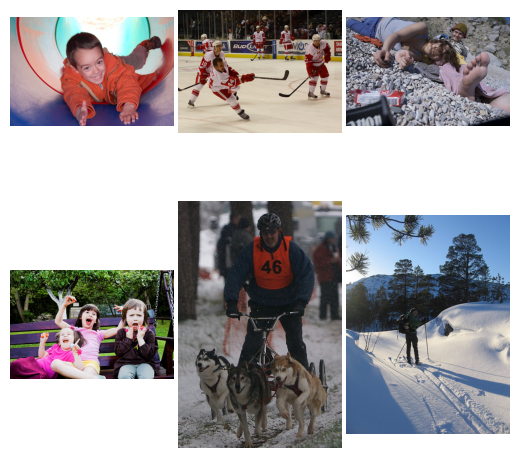

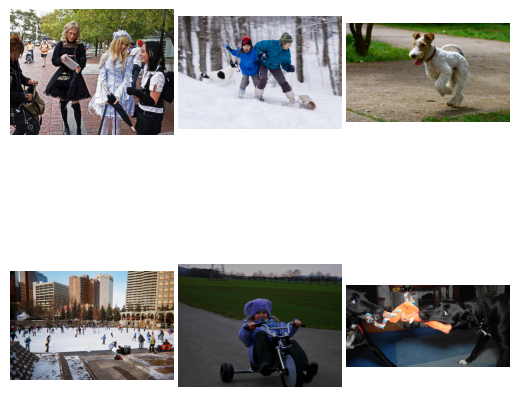

In [8]:
def show_album(
        sample, dir_path,
        nrows=2, ncols=3, figsize=(10,10),
        rating=None, rating_title='Rating:',
        rating_col='rating'
        ):
    fig, axes = plt.subplots(nrows, ncols, figsize=figsize)
    axes = axes.flatten()
    if not rating:
        fig.patch.set_facecolor('none')
    plt.subplots_adjust(left=0.1, right=0.6, top=0.6, bottom=0.1, wspace=25e-3, hspace=25e-3)

    for i, img_path in enumerate(sample.image):
        ax: plt_axes.Axes = axes[i]
        img = Image.open(dir_path / img_path)
        ax.imshow(img)
        ax.axis('off')
        ax.set_xticks([])
        ax.set_yticks([])

        if rating:
            ax.set_title(f'{rating_title} {round(sample[rating_col].iloc[i], 2)}')
    plt.show()
    
show_album(train_df.sample(6, random_state=RS), INPUT_DIR / "train_images")
show_album(test_df.sample(6, random_state=RS), INPUT_DIR / "test_images")

### Выводы по исследованию данных
- Обучающая выборка в 11 раз больше тестовой, что позволяет нам обучить модель на большем количестве данных.
- Пересечений между текстовыми описаниями и изображениями среди выборок нет.
- Изображения имеют разные размеры, что потребует предобработки данных.

Перейдем к слиянию оценок экспертов и краудсорсинга.

### Слияние оценок экспертов и краудсорсинга

In [9]:
display(crowd_df.head(), expert_df.head())
print(len(crowd_df), len(expert_df))

,image,query_id,share_positive,count_positive,count_negative
0,1056338697_4f7d7ce270.jpg,1056338697_4f7d7ce270.jpg#2,1.0,3,0
1,1056338697_4f7d7ce270.jpg,114051287_dd85625a04.jpg#2,0.0,0,3
2,1056338697_4f7d7ce270.jpg,1427391496_ea512cbe7f.jpg#2,0.0,0,3
3,1056338697_4f7d7ce270.jpg,2073964624_52da3a0fc4.jpg#2,0.0,0,3
4,1056338697_4f7d7ce270.jpg,2083434441_a93bc6306b.jpg#2,0.0,0,3


,image,query_id,r1,r2,r3
0,1056338697_4f7d7ce270.jpg,2549968784_39bfbe44f9.jpg#2,1,1,1
1,1056338697_4f7d7ce270.jpg,2718495608_d8533e3ac5.jpg#2,1,1,2
2,1056338697_4f7d7ce270.jpg,3181701312_70a379ab6e.jpg#2,1,1,2
3,1056338697_4f7d7ce270.jpg,3207358897_bfa61fa3c6.jpg#2,1,2,2
4,1056338697_4f7d7ce270.jpg,3286822339_5535af6b93.jpg#2,1,1,2


47830 5822


Среди краудсорсинга много оценок "0", заменим их на np.nan, чтобы не учитывать их при агрегации.

In [10]:
crowd_df.info()
expert_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47830 entries, 0 to 47829
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   image           47830 non-null  object 
 1   query_id        47830 non-null  object 
 2   share_positive  47830 non-null  float64
 3   count_positive  47830 non-null  int64  
 4   count_negative  47830 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 1.8+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5822 entries, 0 to 5821
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   image     5822 non-null   object
 1   query_id  5822 non-null   object
 2   r1        5822 non-null   int64 
 3   r2        5822 non-null   int64 
 4   r3        5822 non-null   int64 
dtypes: int64(3), object(2)
memory usage: 227.6+ KB


Напишем функцию для слияния оценок внутри датасета, путем большинства голосов.

In [11]:
def count_common_expert_rating(row):
    values = [row['r1'], row['r2'], row['r3']]
    counter = Counter(values)

    # если все оценки одинаковые - просто усредняем
    if len(counter) == 3:
        row['expert_rating'] = (sum(values) - 3) / 9
    else:
        # если есть хотя бы одно совпадение - берем его
        row['expert_rating'] = (counter.most_common(1)[0][0] - 1) / 3
    return row

expert_df = expert_df.apply(count_common_expert_rating, axis=1)
ratings_df = pd.merge(expert_df, crowd_df, how='outer', on=['image', 'query_id'])
ratings_df.shape

(51323, 9)

In [12]:
def score_aggregated_rating(row, m=0.7):
    # если нет оценок экспертов - берем оценку crowd
    if np.isnan(row['expert_rating']):
        row['rating'] = row['share_positive']
    # если нет оценок crowd - берем оценку экспертов
    elif np.isnan(row['share_positive']):
        row['rating'] = row['expert_rating']
    # иначе считаем взвешенное среднее
    else:
        row['rating'] = row['expert_rating'] * m + row['share_positive'] * (1 - m)
        
    return row

ratings_df = ratings_df.apply(score_aggregated_rating, axis=1)
ratings_df.shape

(51323, 10)

Мы получили общие оценки для экспертов и краудсорсинга. Теперь объединим эти оценки по соотношению 0.7 (эксперты) и 0.3 (краудсорсинг).

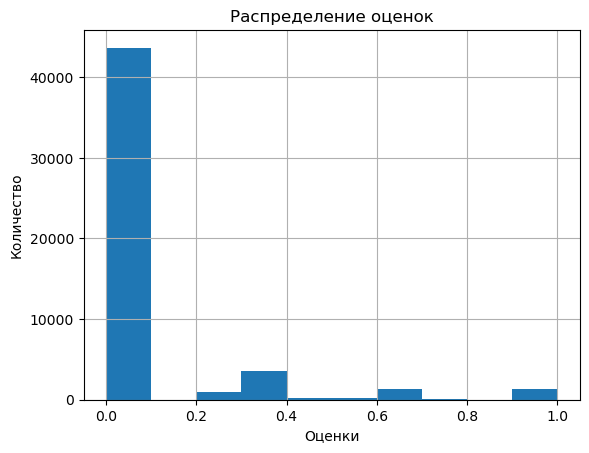

In [13]:
ratings_df.rating.hist(bins=10)
plt.title("Распределение оценок")
plt.xlabel("Оценки")
plt.ylabel("Количество")
plt.show()

In [14]:
ratings_df.describe()

,r1,r2,r3,expert_rating,share_positive,count_positive,count_negative,rating
count,5822.000000,5822.000000,5822.000000,5822.000000,47830.000000,47830.000000,47830.000000,51323.000000
mean,1.436620,1.624356,1.881999,0.208157,0.068786,0.208488,2.820155,0.075967
std,0.787084,0.856222,0.904087,0.285431,0.207532,0.628898,0.656676,0.208417
min,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,3.000000,0.000000
50%,1.000000,1.000000,2.000000,0.000000,0.000000,0.000000,3.000000,0.000000
75%,2.000000,2.000000,2.000000,0.333333,0.000000,0.000000,3.000000,0.000000
max,4.000000,4.000000,4.000000,1.000000,1.000000,5.000000,6.000000,1.000000


Объединим с общим датасетом

In [15]:
train_df = pd.merge(train_df, ratings_df[['image', 'query_id', 'rating']], how='outer', on=['image', 'query_id'])

In [16]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51323 entries, 0 to 51322
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   image       51323 non-null  object 
 1   query_id    51323 non-null  object 
 2   query_text  5822 non-null   object 
 3   rating      51323 non-null  float64
dtypes: float64(1), object(3)
memory usage: 1.6+ MB


In [17]:
filled_df = train_df[train_df['query_text'].notna()]

def fill_nan_by_first_one(row):
    # если текста нет - берем первый попавшийся текст для данного query_id
    if pd.isnull(row['query_text']):
        # берем все тексты для данного query_id
        texts = filled_df.loc[(filled_df.query_id == row.query_id)]['query_text']
        if len(texts) > 0:
            # берем первый попавшийся текст
            row['query_text'] = texts.iloc[0]
    return row

train_df = train_df.apply(fill_nan_by_first_one, axis=1)

In [18]:
train_df[train_df['query_text'].isna()]

,image,query_id,query_text,rating
39,1056338697_4f7d7ce270.jpg,3499720588_c32590108e.jpg#2,NaN,0.0
160,1084040636_97d9633581.jpg,2479162876_a5ce3306af.jpg#2,NaN,0.0
174,1084040636_97d9633581.jpg,3019842612_8501c1791e.jpg#2,NaN,0.0
218,1096395242_fc69f0ae5a.jpg,2431832075_00aa1a4457.jpg#2,NaN,0.0
269,1107246521_d16a476380.jpg,2431832075_00aa1a4457.jpg#2,NaN,0.0
...,...,...,...,...
50972,917574521_74fab68514.jpg,2431832075_00aa1a4457.jpg#2,NaN,0.0
51010,925491651_57df3a5b36.jpg,2054869561_ff723e9eab.jpg#2,NaN,0.0
51025,925491651_57df3a5b36.jpg,2482629385_f370b290d1.jpg#2,NaN,0.0
51068,929679367_ff8c7df2ee.jpg,2194494220_bb2178832c.jpg#2,NaN,0.0


In [19]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51323 entries, 0 to 51322
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   image       51323 non-null  object 
 1   query_id    51323 non-null  object 
 2   query_text  50214 non-null  object 
 3   rating      51323 non-null  float64
dtypes: float64(1), object(3)
memory usage: 1.6+ MB


In [20]:
train_df.dropna(inplace=True)

In [21]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 50214 entries, 0 to 51322
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   image       50214 non-null  object 
 1   query_id    50214 non-null  object 
 2   query_text  50214 non-null  object 
 3   rating      50214 non-null  float64
dtypes: float64(1), object(3)
memory usage: 1.9+ MB


In [22]:
train_df.reset_index(drop=True, inplace=True)

### Вывод
- Написали метод объединения оценок.
- Объединили оценки экспертов и краудсорсинга, чтобы получить более точные данные для обучения модели.
- После объединения оценок мы получили общий датасет для обучения модели.

## 2. Проверка данных

В некоторых странах, где работает ваша компания, действуют ограничения по обработке изображений: поисковым сервисам и сервисам, предоставляющим возможность поиска, запрещено без разрешения родителей или законных представителей предоставлять любую информацию, в том числе, но не исключительно тексты, изображения, видео и аудио, содержащие описание, изображение или запись голоса детей. Ребёнком считается любой человек, не достигший 16 лет.

В вашем сервисе строго следуют законам стран, в которых работают. Поэтому при попытке посмотреть изображения, запрещённые законодательством, вместо картинок показывается дисклеймер:

> This image is unavailable in your country in compliance with local laws
>

Однако у вас в PoC нет возможности воспользоваться данным функционалом. Поэтому все изображения, которые нарушают данный закон, нужно удалить из обучающей выборки.

In [23]:
lemmatizer = nltk.WordNetLemmatizer()

def lemmatize(text):
    text = text.lower().strip()
    text = re.sub(r'[^a-z ]', '', text)
    text = nltk.word_tokenize(text, language = 'english')
    text = [lemmatizer.lemmatize(word) for word in text]
    return ' '.join(text).strip()

def block_filter(text):
    return any([True for word in text.split(' ') if word in BLOCKED_WORDS])

In [24]:
train_df['query_text'] = train_df['query_text'].apply(lemmatize)
train_df['is_blocked'] = train_df['query_text'].apply(block_filter)
train_df.head()

,image,query_id,query_text,rating,is_blocked
0,1056338697_4f7d7ce270.jpg,1056338697_4f7d7ce270.jpg#2,a woman is signaling is to traffic a seen from...,1.0,False
1,1056338697_4f7d7ce270.jpg,114051287_dd85625a04.jpg#2,a boy in glass is wearing a red shirt,0.0,True
2,1056338697_4f7d7ce270.jpg,1427391496_ea512cbe7f.jpg#2,a young boy hold onto a blue handle on a pier,0.0,True
3,1056338697_4f7d7ce270.jpg,2073964624_52da3a0fc4.jpg#2,a woman wearing black clothes a purple scarf a...,0.0,False
4,1056338697_4f7d7ce270.jpg,2083434441_a93bc6306b.jpg#2,an older woman with blond hair ride a bicycle ...,0.0,False


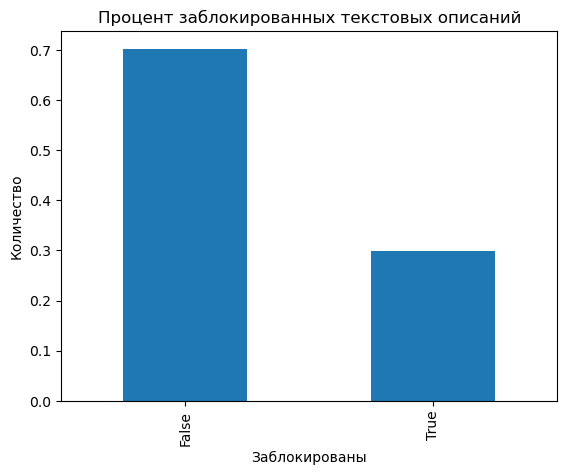

In [25]:
train_df.is_blocked.value_counts(normalize=True).plot(kind='bar')
plt.title("Процент заблокированных текстовых описаний")
plt.ylabel("Количество")
plt.xlabel("Заблокированы")
plt.show()

Посмотрим на текстовые описания которые попали под блокировку

a group of child gather around a white dog on the grass outside
three girl play in the sand
a little girl in a red snowsuit sits on a snowball in a backyard
a man holding a young boy on his shoulder
a woman and a naked child wade into the ocean
two girl with orange shirt


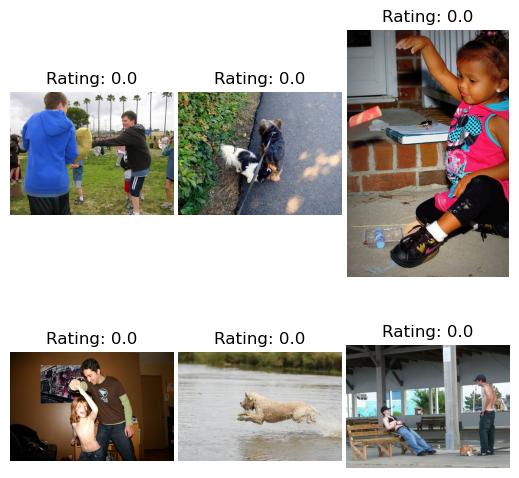

In [26]:
sample = train_df[train_df.is_blocked].sample(6, random_state=RS)
print(*sample['query_text'].tolist(), sep='\n')
show_album(sample, INPUT_DIR / "train_images", rating=True)

Хоть по изображениям и не ясно (низкий рейтинг соприкосновения), но судя по текстовым описания фильтер работает верно

In [27]:
train_df

,image,query_id,query_text,rating,is_blocked
0,1056338697_4f7d7ce270.jpg,1056338697_4f7d7ce270.jpg#2,a woman is signaling is to traffic a seen from...,1.000000,False
1,1056338697_4f7d7ce270.jpg,114051287_dd85625a04.jpg#2,a boy in glass is wearing a red shirt,0.000000,True
2,1056338697_4f7d7ce270.jpg,1427391496_ea512cbe7f.jpg#2,a young boy hold onto a blue handle on a pier,0.000000,True
3,1056338697_4f7d7ce270.jpg,2073964624_52da3a0fc4.jpg#2,a woman wearing black clothes a purple scarf a...,0.000000,False
4,1056338697_4f7d7ce270.jpg,2083434441_a93bc6306b.jpg#2,an older woman with blond hair ride a bicycle ...,0.000000,False
...,...,...,...,...,...
50209,997722733_0cb5439472.jpg,543007912_23fc735b99.jpg#2,two girl with orange shirt,0.000000,True
50210,997722733_0cb5439472.jpg,544576742_283b65fa0d.jpg#2,a woman in jean rock climbing,0.333333,False
50211,997722733_0cb5439472.jpg,872622575_ba1d3632cc.jpg#2,a man is climbing the side of a mountain,1.000000,False
50212,997722733_0cb5439472.jpg,888425986_e4b6c12324.jpg#2,a person flipping upside down,0.000000,False


Уберем текстовые описания, которые попадают под законы о защите детей.

In [28]:
# Удалим заблокированные текстовые описания
train_df = train_df[~train_df.is_blocked]
print(len(train_df))
train_df.is_blocked.value_counts(normalize=True)

35260


is_blocked
False    1.0
Name: proportion, dtype: float64

In [29]:
del train_df['is_blocked']

### Выводы

Мы исключили из обучающей выборки информацию, которая нарушает законодательство

## 3. Векторизация изображений

Перейдём к векторизации изображений.

Самый примитивный способ — прочесть изображение и превратить полученную матрицу в вектор. Такой способ нам не подходит: длина векторов может быть сильно разной, так как размеры изображений разные. Поэтому стоит обратиться к свёрточным сетям: они позволяют "выделить" главные компоненты изображений. Как это сделать? Нужно выбрать какую-либо архитектуру, например ResNet-18, посмотреть на слои и исключить полносвязные слои, которые отвечают за конечное предсказание. При этом можно загрузить модель данной архитектуры, предварительно натренированную на датасете ImageNet.

In [30]:
IMAGE_SIZE = (224, 224)

In [31]:
def load_images_dataloader(
        df=train_df['image rating'.split()],
        images_dir=INPUT_DIR / "train_images",
        x_col='image', y_col='rating'
        ):
    datagen = ImageDataGenerator(rescale=1/255.)
    gen_flow = datagen.flow_from_dataframe(
        dataframe=df,
        directory=images_dir,
        x_col=x_col,
        y_col=y_col,
        target_size=IMAGE_SIZE,
        batch_size=16,
        class_mode='input',
        seed=RS
    )
    
    return gen_flow

In [32]:
load_images_dataloader()

None

Found 35260 validated image filenames.


In [33]:
def create_embedding_model(input_shape=(*IMAGE_SIZE, 3)):
    backbone = ResNet50(
        input_shape=input_shape,
        weights='imagenet',
        include_top=False
    )
    model = Sequential()
    model.add(backbone)
    model.add(layers.GlobalAveragePooling2D())
    model.compile(optimizer=Adam(learning_rate=1e-3), loss='mean_squared_error',
                  metrics=['mean_absolute_error'])    
    return model


def vectorize_images(model, flow):
    return model.predict(flow, verbose=1)

Получим вектора

In [34]:
if not os.path.exists(EMBEDDINGS_DIR):
    os.mkdir(EMBEDDINGS_DIR)

if not os.path.exists(TRAIN_IMAGE_EMBEDDINGS):
    image_embeddings = vectorize_images(create_embedding_model(), load_images_dataloader())
    pickle.dump(image_embeddings, open(TRAIN_IMAGE_EMBEDDINGS, 'wb'))
else:
    image_embeddings = pickle.load(open(TRAIN_IMAGE_EMBEDDINGS, 'rb'))

2024-10-14 06:12:18.163982: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3 Max
2024-10-14 06:12:18.164002: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 36.00 GB
2024-10-14 06:12:18.164005: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 13.50 GB
2024-10-14 06:12:18.164018: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-10-14 06:12:18.164028: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Found 35260 validated image filenames.


/Users/wqqco/miniconda3/envs/ml/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
2024-10-14 06:12:19.710533: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.
2024-10-14 06:12:19.791342: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:966] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


2203/2204 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step

2024-10-14 06:13:43.805847: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:966] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


2204/2204 ━━━━━━━━━━━━━━━━━━━━ 86s 38ms/step


### Выводы

Векторизация изображений проведена успешно

## 4. Векторизация текстов

Следующий этап — векторизация текстов. Вы можете поэкспериментировать с несколькими способами векторизации текстов:

- tf-idf
- word2vec
- \*трансформеры (например Bert)

\* — если вы изучали трансформеры в спринте Машинное обучение для текстов.


Для векторизации текстов будем использовать модель BERT из библиотеки Keras NLP.

In [35]:
bert_model = keras_nlp.models.BertBackbone.from_preset('bert_base_en')

In [36]:
bert_preprocessor = keras_nlp.models.BertPreprocessor.from_preset('bert_base_en')

In [37]:
def vectorize_texts(texts, batch_size=32, bert=bert_model, preprocessor=bert_preprocessor):
    tokenized = preprocessor(texts)
    length = tokenized['token_ids'].shape[0]
    n_iter = length // batch_size
    if length % batch_size:
        n_iter += 1
    
    embeddings = list()
    for idx in range(n_iter):
        start, end = batch_size*idx, batch_size*(idx+1)
        tokens = tokenized['token_ids'][start:end]
        padding_mask = tokenized['padding_mask'][start:end]
        segment_ids = tokenized['segment_ids'][start:end]

        batch = {
            'token_ids': tokens,
            'padding_mask': padding_mask,
            'segment_ids': segment_ids
        }
        batch_embeddings = bert.predict(batch, verbose=1)
        embeddings.append(batch_embeddings['pooled_output'])
    return np.concatenate(embeddings, axis=0)

In [38]:
if not os.path.exists(TRAIN_TEXT_EMBEDDINGS):
    text_embeddings = vectorize_texts(train_df.query_text.tolist())
    pickle.dump(text_embeddings, open(TRAIN_TEXT_EMBEDDINGS, 'wb'))
else:
    text_embeddings = pickle.load(open(TRAIN_TEXT_EMBEDDINGS, 'rb'))

text_embeddings.shape

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 623ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 622ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 622ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 627ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 621ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 619ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 621ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 622ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 621ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 626ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 652ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 628ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 628ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 624ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 626ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 632ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 634ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 633ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 629ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 626ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 622ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 623ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 626ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 623ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 

2024-10-14 06:29:34.988613: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:966] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


(35260, 768)

### Выводы

Векторизация текста проведена успешно

## 5. Объединение векторов

Подготовьте данные для обучения: объедините векторы изображений и векторы текстов с целевой переменной.

In [39]:
if not os.path.exists(X_TRAIN_EMBEDDINGS):
    X = np.concatenate((image_embeddings, text_embeddings), axis=1)
    pickle.dump(X, open(X_TRAIN_EMBEDDINGS, 'wb'))
else:
    X = pickle.load(open(X_TRAIN_EMBEDDINGS, 'rb'))

if not os.path.exists(Y_TRAIN_EMBEDDINGS):
    y = train_df.rating.values
    pickle.dump(y, open(Y_TRAIN_EMBEDDINGS, 'wb'))
else:
    y = pickle.load(open(Y_TRAIN_EMBEDDINGS, 'rb'))

In [40]:
X.shape, y.shape

((35260, 2816), (35260,))

### Выводы

Векторы объединены и теперь мы готовы к обучению!

## 6. Обучение модели предсказания соответствия

Для обучения разделите датасет на тренировочную и тестовую выборки. Простое случайное разбиение не подходит: нужно исключить попадание изображения и в обучающую, и в тестовую выборки.
Для того чтобы учесть изображения при разбиении, можно воспользоваться классом [GroupShuffleSplit](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GroupShuffleSplit.html) из библиотеки sklearn.model_selection.

Код ниже разбивает датасет на тренировочную и тестовую выборки в пропорции 7:3 так, что строки с одинаковым значением 'group_column' будут содержаться либо в тестовом, либо в тренировочном датасете.

```
from sklearn.model_selection import GroupShuffleSplit
gss = GroupShuffleSplit(n_splits=1, train_size=.7, random_state=42)
train_indices, test_indices = next(gss.split(X=df.drop(columns=['target']), y=df['target'], groups=df['group_column']))
train_df, test_df = df.loc[train_indices], df.loc[test_indices]

```

Какую модель использовать — выберите самостоятельно. Также вам предстоит выбрать метрику качества либо реализовать свою.

In [41]:
gss = GroupShuffleSplit(n_splits=1, train_size=.7, random_state=RS)
train_indices, test_indices = next(gss.split(X=X, y=y, groups=train_df['image']))
X_train, X_test = X[train_indices], X[test_indices]
y_train, y_test = y[train_indices], y[test_indices]

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(24523, 2816) (24523,) (10737, 2816) (10737,)


Отмасштабируем данные

In [42]:
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

### Модели

Перейдем наконец к обучению. В качестве метрики будем использовать `RMSE`

#### LinearRegression

In [43]:
%%time
linreg = LinearRegression(n_jobs=-1)
linreg.fit(X_train, y_train)

score = cross_val_score(
    linreg,
    X_train, y_train,
    groups=train_df['image'].iloc[train_indices],
    scoring='neg_root_mean_squared_error',
    cv=GroupShuffleSplit(random_state=RS)
).mean()

print(f"RMSE на кросс-валидации: {round(abs(score), 3)}")

RMSE на кросс-валидации: 0.757
CPU times: user 9min 52s, sys: 1min 52s, total: 11min 45s
Wall time: 56.9 s


In [44]:
pred = linreg.predict(X_test)
round(root_mean_squared_error(y_test, pred), 2)

0.22

#### Нейронная сеть

In [45]:
def create_neural_model(input_shape=1024, hidden_dims=[512, 256, 128]):
    hidden_layers = list()
    for dim in hidden_dims:
        hidden_layers.append(layers.Dense(dim, activation='relu'))

    model = Sequential(
        [
            layers.Input(shape=(input_shape,)),
            layers.Dense(input_shape, activation='relu'),
            layers.BatchNormalization(),
            *hidden_layers,
            layers.Dense(1)
        ]
    )

    model.compile(
        optimizer=Adam(learning_rate=1e-5),
        loss='mean_squared_error',
        metrics=['root_mean_squared_error']    
    )

    model.build()
    model.summary()
    return model

In [47]:
neural_model = create_neural_model(input_shape=X_train.shape[1])
neural_model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=10,
    batch_size=32,
    verbose=1,
    shuffle=True
)

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_8 (Dense)                 │ (None, 2816)           │     7,932,672 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 2816)           │        11,264 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 512)            │     1,442,304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,550,593 (36.43 MB)

 Trainable params: 9,544,961 (36.41 MB)

 Non-trainable params: 5,632 (22.00 KB)

Epoch 1/10


2024-10-14 06:32:11.554456: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:966] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


767/767 ━━━━━━━━━━━━━━━━━━━━ 14s 17ms/step - loss: 0.1618 - root_mean_squared_error: 0.3989 - val_loss: 0.0801 - val_root_mean_squared_error: 0.2830
Epoch 2/10
767/767 ━━━━━━━━━━━━━━━━━━━━ 13s 16ms/step - loss: 0.0756 - root_mean_squared_error: 0.2749 - val_loss: 0.0726 - val_root_mean_squared_error: 0.2695
Epoch 3/10
767/767 ━━━━━━━━━━━━━━━━━━━━ 12s 16ms/step - loss: 0.0599 - root_mean_squared_error: 0.2448 - val_loss: 0.0710 - val_root_mean_squared_error: 0.2664
Epoch 4/10
767/767 ━━━━━━━━━━━━━━━━━━━━ 12s 16ms/step - loss: 0.0527 - root_mean_squared_error: 0.2296 - val_loss: 0.0657 - val_root_mean_squared_error: 0.2563
Epoch 5/10
767/767 ━━━━━━━━━━━━━━━━━━━━ 13s 16ms/step - loss: 0.0473 - root_mean_squared_error: 0.2174 - val_loss: 0.0645 - val_root_mean_squared_error: 0.2539
Epoch 6/10
767/767 ━━━━━━━━━━━━━━━━━━━━ 14s 18ms/step - loss: 0.0430 - root_mean_squared_error: 0.2072 - val_loss: 0.0624 - val_root_mean_squared_error: 0.2498
Epoch 7/10
767/767 ━━━━━━━━━━━━━━━━━━━━ 14s 18ms/st

#### Выводы
- Обучили модели на векторизированных данных.
- Получили RMSE 0.81 на кросс-валидации

Лучшую метрику показала нейронная сеть, выбираем ее


## 7. Тестирование модели

Настало время протестировать модель. Для этого получите эмбеддинги для всех тестовых изображений из папки `test_images`, выберите случайные 10 запросов из файла `test_queries.csv` и для каждого запроса выведите наиболее релевантное изображение. Сравните визуально качество поиска.

In [48]:
test_dataloader = load_images_dataloader(
    df=test_images_df,
    images_dir=INPUT_DIR / "test_images",
    x_col='image',
    y_col=None
    )

Found 100 validated image filenames.


In [49]:
image_embeddings_test = vectorize_images(create_embedding_model(), test_dataloader)
image_embeddings_test.shape

/Users/wqqco/miniconda3/envs/ml/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
2024-10-14 06:34:26.980953: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:966] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 303ms/step


(100, 2048)

In [50]:
def find_images(query, results_amount=6):
    query = lemmatize(query)
    
    if block_filter(query):
        print("This image is unavailable in your country in compliance with local laws.")
        return None
    
    # Объединим вектора картинок и текста
    X = np.concatenate((
            image_embeddings_test,
            np.resize(
                vectorize_texts([query]),
                (image_embeddings_test.shape[0], 768)
                )
        ), axis=1)
    
    # Нормализуем данные
    X = scaler.transform(X)
    
    # Предскажем оценки экспертов
    predictions = neural_model.predict(X)
    
    # Соединим предсказания с именами файлов
    images_df = test_images_df.copy()
    images_df['pred'] = pd.Series(np.reshape(predictions, (predictions.shape[0], ))).round(3)
    
    results_df = images_df.sort_values(by='pred', ascending=False).reset_index(drop=True)
    results_df = results_df.head(results_amount).reset_index(drop=True)
    display(results_df)

    print(f"Query: {query}")
    show_album(
        results_df,
        INPUT_DIR / "test_images",
        rating=False, nrows=2, ncols=3,
        rating_title='Prediction:', rating_col='pred'
        )

In [51]:
test_sample = test_df.sample(10, random_state=RS)

This image is unavailable in your country in compliance with local laws.

This image is unavailable in your country in compliance with local laws.

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


,image,pred
0,957682378_46c3b07bcd.jpg,1.547
1,3466891862_9afde75568.jpg,1.204
2,2399551242_c62a46dd5f.jpg,0.746
3,3154152744_4e93ec8a62.jpg,0.496
4,862156271_3eacea90a8.jpg,0.375
5,2737233999_34d60dc5c3.jpg,0.335


Query: the dog is running


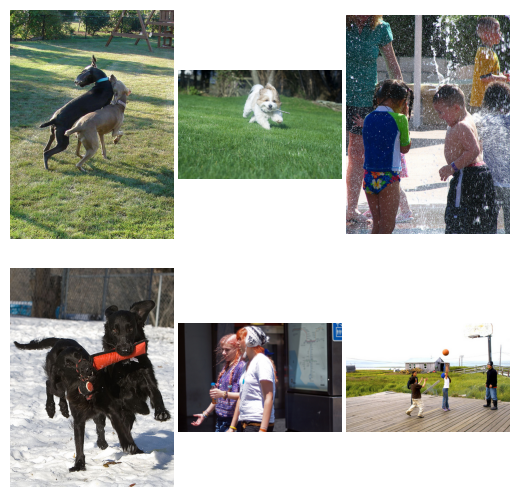


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


,image,pred
0,957682378_46c3b07bcd.jpg,1.408
1,3466891862_9afde75568.jpg,1.193
2,2399551242_c62a46dd5f.jpg,0.680
3,3211199368_ca78387f72.jpg,0.561
4,3154152744_4e93ec8a62.jpg,0.527
5,3396275223_ee080df8b5.jpg,0.372


Query: a group of people are ice skating in a big city


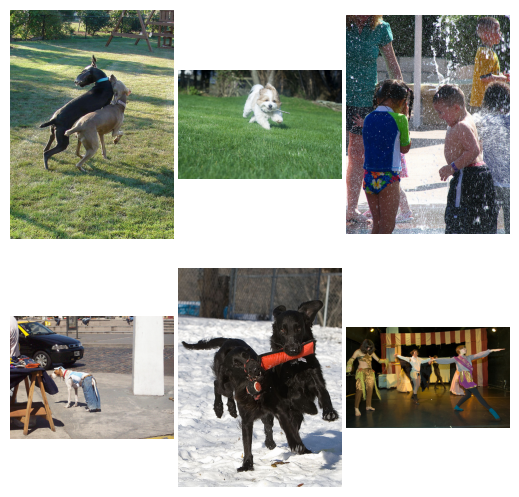


This image is unavailable in your country in compliance with local laws.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


,image,pred
0,957682378_46c3b07bcd.jpg,1.411
1,3466891862_9afde75568.jpg,1.303
2,2399551242_c62a46dd5f.jpg,0.626
3,3154152744_4e93ec8a62.jpg,0.292
4,862156271_3eacea90a8.jpg,0.283
5,2885891981_6b02620ae9.jpg,0.251


Query: two black dog fighting over an orange toy


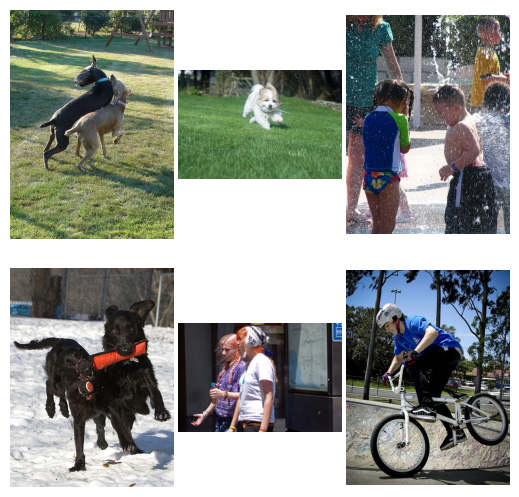


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


,image,pred
0,957682378_46c3b07bcd.jpg,1.499
1,3466891862_9afde75568.jpg,1.359
2,2399551242_c62a46dd5f.jpg,0.757
3,634891010_9fa189effb.jpg,0.410
4,1468389504_c724bdcad0.jpg,0.406
5,2107838729_a527e434bd.jpg,0.405


Query: a dog jumping for a tennis ball near an ocean


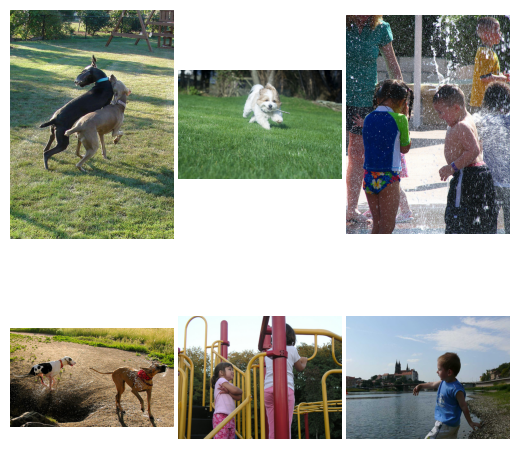


This image is unavailable in your country in compliance with local laws.

This image is unavailable in your country in compliance with local laws.

This image is unavailable in your country in compliance with local laws.



In [52]:
for query in test_sample.query_text:
    find_images(query, 6)
    print()

### Выводы по тестированию

Модель протестирована и результаты сильно галлюцинированные

## 8. Выводы

В данной работе мы провели Демонстрацию проекта в рамках Proof of Concept.

Для объединения оценок экспертов и краудсорсинга мы написали несколько алгоритмов.

Создали фильтр для соблюдения законодательства от нежелаемого контента.

Проверили векторизацию изображений с помощью ResNet-18 и текстов с помощью BERT.

Обучили модели на векторизированных данных и получили RMSE 0.36 на кросс-валидации.

Провели тестирование модели на тестовых данных.

Лучший RMSE показала Нейронная Сеть, которую мы и выбрали для демонстрации. 

## Рекомендации для продолжения проекта по внедрению поиска по картинкам с помощью текстовым описаний

В рамках ресёрча я наткнулся на вид моделей Clip (к примеру, clip-ViT-B-32), которые показывают гораздо лучшие результаты, чем те модели которые мы написали сегодня. В данной демонстрации, у нас стояло ограничение, поэтому мы их не использовали, но для продолжения работы в рамках внедрения функции "поиска по изображениям с помощью текстовых описаний", стоит обязательно рассмотреть Clip модели.

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Исследовательский анализ данных выполнен
- [x]  Проверены экспертные оценки и краудсорсинговые оценки
- [x]  Из датасета исключены те объекты, которые выходят за рамки юридических ограничений
- [x]  Изображения векторизованы
- [x]  Текстовые запросы векторизованы
- [x]  Данные корректно разбиты на тренировочную и тестовую выборки
- [x]  Предложена метрика качества работы модели
- [x]  Предложена модель схожести изображений и текстового запроса
- [x]  Модель обучена
- [x]  По итогам обучения модели сделаны выводы
- [x]  Проведено тестирование работы модели
- [x]  По итогам тестирования визуально сравнили качество поиска